<a href="https://colab.research.google.com/github/Kashara-Alvin-Ssali/Explainable-Ai-for-The-ML-Models/blob/main/GAT_Saliency_XAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
# Install required libraries (if not already installed)
!pip install torch torchvision torchaudio torch-geometric captum networkx opencv-python matplotlib


In [99]:
import torch
import cv2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, global_mean_pool
from scipy.spatial import Delaunay
from captum.attr import Saliency
import torch.nn.functional as F

In [100]:
# prompt: code for mounting drive

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
# Define GAT model class
class GATClassifier(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2, heads=2):
        super(GATClassifier, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, data.batch)
        x = self.fc(x)
        return x


In [102]:
# Function to compute graph using ORB + Delaunay
def compute_orb_graph(image):
    orb = cv2.ORB_create(nfeatures=700, scaleFactor=1.2, nlevels=8, edgeThreshold=15)
    keypoints, descriptors = orb.detectAndCompute(image, None)
    if not keypoints or descriptors is None:
        return None, None, None
    points = np.array([kp.pt for kp in keypoints], dtype=np.float32)
    G = nx.Graph()
    for i, (x, y) in enumerate(points):
        G.add_node(i, pos=(x, y), descriptor=descriptors[i])
    if len(points) > 2:
        tri = Delaunay(points)
        for simplex in tri.simplices:
            for i in range(3):
                G.add_edge(simplex[i], simplex[(i + 1) % 3])
    return G, keypoints, descriptors

In [103]:
# Load trained model
model = GATClassifier(input_dim=32).to('cpu')
model.load_state_dict(torch.load('/content/drive/MyDrive/gat_model.pth', map_location=torch.device('cpu')))
model.eval()

GATClassifier(
  (conv1): GATConv(32, 64, heads=2)
  (conv2): GATConv(128, 64, heads=1)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [105]:
# Load and process an example image
image_path = '/content/drive/MyDrive/Dataset4/Training/Fake/14.jpg'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
G, keypoints, descriptors = compute_orb_graph(image)
edge_index = torch.tensor(list(G.edges), dtype=torch.long).t().contiguous()
x = torch.tensor(np.array([G.nodes[i]['descriptor'] for i in G.nodes]), dtype=torch.float)
data = Data(x=x, edge_index=edge_index, batch=torch.zeros(x.shape[0], dtype=torch.long))


In [106]:
# Saliency computation
saliency = Saliency(lambda inputs: model(Data(x=inputs, edge_index=edge_index, batch=data.batch)).log_softmax(dim=1))
inputs = data.x.clone().detach().requires_grad_(True)
attributions = saliency.attribute(inputs, target=model(data).argmax().item()).detach().numpy()
node_importance = np.linalg.norm(attributions, axis=1)

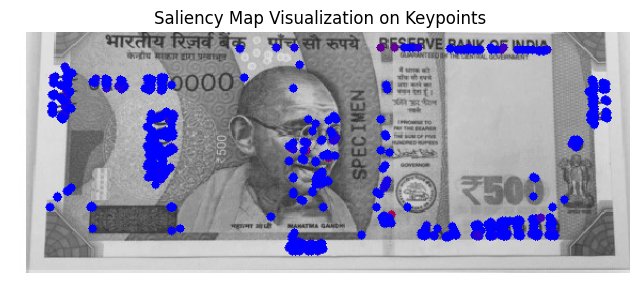

In [108]:
# Visualization with colored keypoints
img_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
# Use np.ptp instead of node_importance.ptp()
norm_imp = (node_importance - node_importance.min()) / (np.ptp(node_importance) + 1e-6)

for i, kp in enumerate(keypoints):
    color = (int(255 * (1 - norm_imp[i])), 0, int(255 * norm_imp[i]))  # Blue to Red gradient
    cv2.circle(img_color, (int(kp.pt[0]), int(kp.pt[1])), 4, color, -1)

plt.figure(figsize=(8, 8))
plt.imshow(img_color[:, :, ::-1])
plt.title("Saliency Map Visualization on Keypoints")
plt.axis('off')
plt.show()